In [1]:
import pandas as pd
import numpy as np
import yaml

# Getting the Data from Config File

In [2]:
config = open("../configs.yaml", "r")
dictionary = yaml.safe_load(config)

In [3]:
# Data Loading Fields
GRADES_FILENAME = dictionary["data_path"]["grades_filename"]

# Lab Fields
NUM_LABS = dictionary["labs"]["num_labs"]
MAX_LABS = dictionary["labs"]["max_labs"]

# Project Fields
NUM_PROJECTS = dictionary["projects"]["num_projects"]
MAX_PROJECTS = dictionary["projects"]["max_projects"]

NUM_PROJECT_CHECKPOINTS = dictionary["projects"]["num_checkpoints"]
MAX_PROJECT_CHECKPOINTS = dictionary["projects"]["max_checkpoints"]

# Midterm fields
YES_MIDTERM = dictionary["exams"]["midterm"]["enabled"]
MIDTERM_VERSIONS = dictionary["exams"]["midterm"]["versions"]
MIDTERM_BONUS = dictionary["exams"]["midterm"]["bonus"]

# Final Fields
YES_FINAL = dictionary["exams"]["final"]["enabled"]
FINAL_VERSIONS = dictionary["exams"]["final"]["versions"]
FINAl_BONUS = dictionary["exams"]["final"]["bonus"]

# Discussion Fields
MAX_DISCUSSION_OFFSET = dictionary["max_discussion_offset"]
MAX_LECTURE_OFFSET = dictionary["max_lecture_offset"]

NUM_DISC_ATTENDENCE_REQUIRED = dictionary["discussions"][
    "num_discussions_attendence_required"
]
NUM_LECT_ATTENDENCE_REQUIRED = dictionary["discussions"][
    "num_lecture_attendence_required"
]

# Number of dropped assignments per category (set to 0 for no drops)
# For example, if NUM_DROPS = 2, then 2 Labs and 2 Homeworks will be dropped
# Note: Set this to 0 until the end of the quarter
NUM_DROPS = dictionary["drop_policy"]["num_drops"]

OVERALL_EC = dictionary["extra_credit"]["overall"]

ASSIGNMENT_WEIGHTS = dictionary["assignment_weights"]
DISCUSSION_OR_LECTURE_ASSIGNMENT_WEIGHTS = dictionary["discussion_or_lecture_assignment_weights"]
DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS = dictionary["discussion_and_lecture_assignment_weights"]

# Late Submission Grace Period (3 Minutes)
GRACE_PERIOD = 3 / 60

# Reading in the Current Grade CSV

In [4]:
df = pd.read_csv(GRADES_FILENAME)
discussion_and_lecture_attendence = pd.read_csv("../data/attendance.csv").drop(
    columns=["Email", "Name"]
)
df = df.merge(discussion_and_lecture_attendence, how='left', on="SID").set_index("SID")

# Create name column if not already present
if "Name" not in df.columns:
    df["Name"] = df["First Name"] + " " + df["Last Name"]
    df = df.drop(["First Name", "Last Name"], axis=1)

# Lab 1 Does not have Redemption Assignement 

In [5]:
# At the beginning of the quarter, we did not do Lab 1 Redemption
def redemption_score(lateness, score):
    if lateness != "00:00:00":
        return score
    else:
        return np.nan


df["Lab 1 Redemption"] = df.apply(
    lambda row: redemption_score(row["Lab 1 - Lateness (H:M:S)"], row["Lab 1"]), axis=1
)
df["Lab 1 Redemption - Max Points"] = df["Lab 1 - Max Points"]

# Fixing few Labs and Projects we did Manual Grading for

In [6]:
df["Lab 9 - Max Points"] /= 2
df["Project 3 Redemption - Max Points"] /= 2

# Fixing the Final Projects

In [7]:
df["Project 4"] = df[
    [
        "Project 4 Notebook PDF (Power Outages)",
        "Project 4 Notebook PDF (League of Legends)",
        "Project 4 Notebook PDF (Recipes and Ratings)",
    ]
].sum(axis=1)

df["Project 4 - Max Points"] = df["Project 4 Notebook PDF (Power Outages) - Max Points"]

df["Project 4 Checkpoint"] = df["Final Project (Checkpoint1)"]
df["Project 4 Checkpoint - Max Points"] = df["Final Project (Checkpoint1) - Max Points"]

df["Project 5 Checkpoint"] = df["Final Project (Checkpoint2)"]
df["Project 5 Checkpoint - Max Points"] = df["Final Project (Checkpoint2) - Max Points"]

# Calculating the Grade for each Assignment

In [8]:
def get_assignment_grade(r, assignment_name):
    num = r[assignment_name]
    den = r[assignment_name + " - Max Points"]

    return num / den

In [9]:
for i in range(1, NUM_LABS + 1):
    assignment_name = f"Lab {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )
    # if i == 1:
    #     pass

    assignment_name = f"Lab {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [10]:
for i in range(1, NUM_PROJECTS + 1):
    assignment_name = f"Project {i}"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

    # 4th project has no redemption
    if i == 4:
        break
    assignment_name = f"Project {i} Redemption"
    df[assignment_name + " Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

In [11]:
for i in range(1, NUM_PROJECT_CHECKPOINTS + 1):
    assignment_name = f"Project {i} Checkpoint"
    df[assignment_name + " Final Grade"] = df.apply(
        get_assignment_grade, axis=1, assignment_name=assignment_name
    )

# Calculating Final Grade with Redemption Assignments

In [12]:
def final_grade_with_redemption(assignment_name):
    df[f"{assignment_name} Final Grade"] = df[f"{assignment_name} Grade"] + (
        (
            df[f"{assignment_name} Redemption Grade"] - df[f"{assignment_name} Grade"]
        ).apply(lambda x: x if x > 0 else 0)
        * 0.8
    ).fillna(0)

In [13]:
df.fillna(0, inplace=True)
# As Project 4 has no redemption, we will calculate the final grade without redemption
redemptions_assignments = [f"Project {i+1}" for i in range(0, NUM_PROJECTS - 1)] + [
    f"Lab {i+1}" for i in range(0, NUM_LABS)
]
for assignment in redemptions_assignments:
    final_grade_with_redemption(assignment)
df["Project 4 Final Grade"] = df["Project 4 Grade"]

# Finding Dropped Lab

In [14]:
def find_dropped_labs(df):
    lab_scores = df[[f"Lab {i} Final Grade" for i in range(1, NUM_LABS + 1)]].fillna(0)
    dropped_labs = np.argsort(np.array(lab_scores))[:NUM_DROPS]
    dropped_labs = np.sort(dropped_labs) + 1
    dropped_labs = [f"Lab {l}" for l in dropped_labs]
    return ", ".join(dropped_labs)


df["Dropped Labs"] = df.apply(find_dropped_labs, axis=1)

# Calculating Midterm and Final Grades

In [15]:
def individual_student_redemption(row):
    if row["Redemption Successful"]:
        post_redemption = (
            row["Midterm Redemption Z-Score"] * row["Midterm std"] + row["Midterm Mean"]
        )
        return np.clip(post_redemption, 0, 1)
    else:
        return row["Midterm Exam Grade"]

In [16]:
if YES_MIDTERM:
    df["Midterm Exam Grade"] = df["Midterm"] / df["Midterm - Max Points"]
    df["Midterm Mean"] = df["Midterm Exam Grade"].dropna().mean()
    df["Midterm std"] = df["Midterm Exam Grade"].dropna().std(ddof=0)
    df["Midterm Z-Score"] = (df["Midterm Exam Grade"] - df["Midterm Mean"]) / df[
        "Midterm std"
    ]
    if YES_FINAL:
        MIDTERM_REDEMPTION_MAX_POINTS = 32
        for version in FINAL_VERSIONS:
            cur_version_final = pd.read_csv(
                f"../data/Final_Exam_Version_Set_Scores/Final_Exam_-_Version_{version}_scores.csv"
            ).set_index("SID")
            redmp_questions = cur_version_final.columns[
                cur_version_final.columns.str.contains(r"\(M\)")
            ]
            redmp_scores = cur_version_final[redmp_questions].sum(axis=1)
            redmp_scores = redmp_scores[~redmp_scores.index.duplicated()]
            # merge the redemp_scores with df
            df = df.assign(
                **{f"redepmtion_v{version}": redmp_scores},
                left_index=True,
                right_index=True,
            )
        df["Redemption Score"] = df[
            [f"redepmtion_v{version}" for version in FINAL_VERSIONS]
        ].sum(axis=1)
        df["Midterm Redemption Mean"] = df["Redemption Score"].dropna().mean()
        df["Midterm Redemption std"] = df["Redemption Score"].dropna().std(ddof=0)
        df["Midterm Redemption Z-Score"] = (
            df["Redemption Score"] - df["Midterm Redemption Mean"]
        ) / df["Midterm Redemption std"]
        df["Redemption Successful"] = (
            df["Midterm Redemption Z-Score"] > df["Midterm Z-Score"]
        )
        df["Midterm Exam Grade Post-Redemption"] = df.apply(
            individual_student_redemption, axis=1
        )

    else:
        df["Midterm Exam Grade Post-Redemption"] = df["Midterm Exam Grade"]

In [17]:
if YES_FINAL:
    df["Final Exam"] = 0
    df["Final Exam - Max Points"] = df["Final Exam - Version A - Max Points"].max()
    for version in FINAL_VERSIONS:
        df["Final Exam"] += df[f"Final Exam - Version {version}"].fillna(0)
    df["Final Exam Grade"] = df["Final Exam"] / df["Final Exam - Max Points"]

# Finding Students who are eligible for Discussion Section

In [22]:
df['discussion_offset'] = np.clip(df['disc_count']/NUM_DISC_ATTENDENCE_REQUIRED, 0, 1)*MAX_DISCUSSION_OFFSET
df['lecture_offset'] = np.clip(df['lecture_count']/NUM_LECT_ATTENDENCE_REQUIRED, 0, 1)*MAX_LECTURE_OFFSET

# Calculating the Maximum Possible Grade Right Now 

In [19]:
df["Max Possible Points"] = (
    NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + NUM_PROJECT_CHECKPOINTS
    / MAX_PROJECT_CHECKPOINTS
    * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["midterm_exam"]
if YES_FINAL:
    df["Max Possible Points"] += ASSIGNMENT_WEIGHTS["final_exam"]
df["Max Possible Points"] *= 100
df["Current Max Possible Score"] = df["Max Possible Points"].max()
df["Current Max Possible Score"].max()

100.0

# Calculating Average Score for Each Assignment Group

## 1 Lab is Dropped

In [21]:
def calculate_lab_mean(row):
    exclude_col = row["Dropped Labs"]
    exclude_col += " Final Grade"
    lab_columns = [f"Lab {i+1} Final Grade" for i in range(0, NUM_LABS)]
    columns_to_include = [
        col for col in lab_columns if col not in [exclude_col, "Exclude"]
    ]
    row_mean = row[columns_to_include].fillna(0).mean()
    return row_mean

In [22]:
Final_Project_Grade = [f"Project {i+1} Final Grade" for i in range(0, NUM_PROJECTS)]
# We are adding Final Project 4 Grade to the list of Final Project Grades twice because it has double weight
Final_Project_Grade.append("Project 4 Final Grade")
Final_Project_Checkpoint_Grade = [
    f"Project {i+1} Checkpoint Final Grade" for i in range(0, NUM_PROJECT_CHECKPOINTS)
]

df["Lab Average"] = df.apply(calculate_lab_mean, axis=1)
df["Project Average"] = df[Final_Project_Grade].fillna(0).mean(axis=1)
df["Project Checkpoint Average"] = (
    df[Final_Project_Checkpoint_Grade].fillna(0).mean(axis=1)
)
if YES_MIDTERM:
    df["Midterm Average"] = df["Midterm Exam Grade Post-Redemption"]
if YES_FINAL:
    df["Final Average"] = df["Final Exam Grade"]

# Claculating Scores for Each Student Without Discussion

In [23]:
df["Overall Score without Discussion or Lecture"] = (
    df["Lab Average"] * NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"] * NUM_PROJECTS / MAX_PROJECTS * ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"] * NUM_PROJECT_CHECKPOINTS / MAX_PROJECT_CHECKPOINTS * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score without Discussion or Lecture"] += (
        df["Midterm Average"] * ASSIGNMENT_WEIGHTS["midterm_exam"]
    )
if YES_FINAL:
    df["Overall Score without Discussion or Lecture"] += (
        df["Final Average"] * ASSIGNMENT_WEIGHTS["final_exam"]
    )

df["Overall Score without Discussion or Lecture"] *= 100

df["Overall Score without Discussion or Lecture"].max()

93.33447344903735

# Claculating Scores for Each Student With Discussion

In [24]:
df["Overall Score with Discussion"] = (
    df["Lab Average"] * NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"]
    * NUM_PROJECTS
    / MAX_PROJECTS
    * ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"]
    * NUM_PROJECT_CHECKPOINTS
    / MAX_PROJECT_CHECKPOINTS
    * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score with Lecture"] += df["Midterm Average"] * (
        ASSIGNMENT_WEIGHTS["midterm_exam"] - df["discussion_offset"] / 2
    )
if YES_FINAL:
    df["Overall Score with Lecture"] += df["Final Average"] * (
        ASSIGNMENT_WEIGHTS["midterm_exam"] - df["discussion_offset"] / 2
    )

df["Overall Score with Discussion"] += df["discussion_offset"]

df["Overall Score with Discussion or Lecture"] *= 100
df["Overall Score with Discussion or Lecture"].max()

94.00947344903734

In [ ]:
df["Overall Score with Lecture"] = (
    df["Lab Average"] * NUM_LABS / MAX_LABS * ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"]
    * NUM_PROJECTS
    / MAX_PROJECTS
    * ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"]
    * NUM_PROJECT_CHECKPOINTS
    / MAX_PROJECT_CHECKPOINTS
    * ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score with Discussion or Lecture"] += df["Midterm Average"] * (
        ASSIGNMENT_WEIGHTS["midterm_exam"] - df["discussion_offset"] / 2
    )
if YES_FINAL:
    df["Overall Score with Discussion or Lecture"] += df["Final Average"] * (
        ASSIGNMENT_WEIGHTS["midterm_exam"] - df["discussion_offset"] / 2
    )

df["Overall Score with Discussion"] += df["discussion_offset"]

df["Overall Score with Discussion or Lecture"] *= 100
df["Overall Score with Discussion or Lecture"].max()

In [25]:
df["Overall Score with Discussion and Lecture"] = (
    df["Lab Average"]
    * NUM_LABS
    / MAX_LABS
    * DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["lab"]
    + df["Project Average"]
    * NUM_PROJECTS
    / MAX_PROJECTS
    * DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["project"]
    + df["Project Checkpoint Average"]
    * NUM_PROJECT_CHECKPOINTS
    / MAX_PROJECT_CHECKPOINTS
    * DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["project_checkpoint"]
)
if YES_MIDTERM:
    df["Overall Score with Discussion and Lecture"] += (
        df["Midterm Average"]
        * DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["midterm_exam"]
    )
if YES_FINAL:
    df["Overall Score with Discussion and Lecture"] += (
        df["Final Average"] * DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["final_exam"]
    )

df[
    "Overall Score with Discussion and Lecture"
] += DISCUSSION_AND_LECTURE_ASSIGNMENT_WEIGHTS["discussion"]

df["Overall Score with Discussion and Lecture"] = (
    df["Overall Score with Discussion and Lecture"]
    * df["Elgible for Discussion and Lecture"]
)

df["Overall Score with Discussion and Lecture"] *= 100
df["Overall Score with Discussion and Lecture"].max()

94.68447344903734

# Finding Current Overall Score

In [26]:

df["Overall Score"] = df.apply(
    lambda row: max(
        row["Overall Score with Discussion and Lecture"],
        row["Overall Score with Discussion or Lecture"],
        row["Overall Score without Discussion or Lecture"],
    ),
    axis=1,
)

In [27]:
df["Used Discussion and Lecture"] = (
    df["Overall Score with Discussion and Lecture"]
    > df["Overall Score with Discussion or Lecture"]
) & (
    df["Overall Score with Discussion and Lecture"]
    > df["Overall Score without Discussion or Lecture"]
)

df["Used Discussion or Lecture"] = (
    df["Overall Score with Discussion or Lecture"]
    > df["Overall Score with Discussion and Lecture"]
) & (
    df["Overall Score with Discussion or Lecture"]
    > df["Overall Score without Discussion or Lecture"]
)

# Calculating Current Grade(Percent / Total Point Possible) for Each Student

In [28]:
df["Current Score"] = df["Overall Score"] / df["Max Possible Points"] * 100

In [29]:
df.reset_index(inplace=True)

<AxesSubplot:>

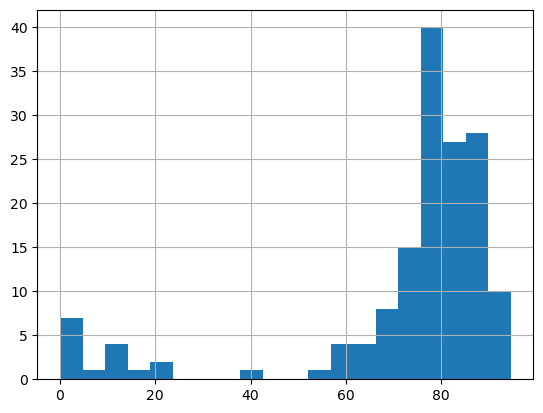

In [30]:
df["Current Score"].hist(bins=20)

In [31]:
df = df.sort_values("Overall Score", ascending=False)
df = df.drop_duplicates(subset='SID', keep='first')
df

,SID,Name,Email,Lab 1,Lab 1 - Max Points,Lab 1 - Submission Time,Lab 1 - Lateness (H:M:S),Project 1 Checkpoint,Project 1 Checkpoint - Max Points,Project 1 Checkpoint - Submission Time,...,Project Checkpoint Average,Midterm Average,Final Average,Overall Score without Discussion or Lecture,Overall Score with Discussion or Lecture,Overall Score with Discussion and Lecture,Overall Score,Used Discussion and Lecture,Used Discussion or Lecture,Current Score
109,A17372175,Rita Yujia Wu,yuw172@ucsd.edu,133.0,133.0,2024-04-24 14:33:56 -0700,326:34:56,13.0,13.0,2024-04-12 17:53:04 -0700,...,1.000,0.80,0.930,93.334473,94.009473,94.684473,94.684473,True,False,94.684473
139,A17466227,Yolanda Feng,yuf019@ucsd.edu,133.0,133.0,2024-05-21 22:20:03 -0700,982:21:03,13.0,13.0,2024-04-12 17:53:04 -0700,...,1.000,0.76,0.930,92.718931,93.493931,94.268931,94.268931,True,False,94.268931
68,A18137549,Jefferson Chen,jec068@ucsd.edu,133.0,133.0,2024-05-08 19:56:02 -0700,667:57:02,13.0,13.0,2024-04-11 15:16:36 -0700,...,1.000,0.80,0.855,90.633450,91.495950,92.358450,92.358450,True,False,92.358450
134,A18078140,Viv Somani,visomani@ucsd.edu,132.0,133.0,2024-04-05 14:20:13 -0700,00:00:00,13.0,13.0,2024-04-09 16:59:03 -0700,...,0.975,0.78,0.900,90.765000,91.565000,0.000000,91.565000,False,True,91.565000
61,A17383701,Hargen Zheng,yoz018@ucsd.edu,133.0,133.0,2024-04-10 22:57:56 -0700,00:00:00,13.0,13.0,2024-04-12 23:57:59 -0700,...,1.000,0.70,0.885,89.241214,90.278714,91.316214,91.316214,True,False,91.316214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,A17404977,Kristina Nguyen,krn002@ucsd.edu,126.0,133.0,2024-04-10 21:55:18 -0700,00:00:00,0.0,13.0,0,...,0.000,0.00,0.000,2.368421,0.000000,0.000000,2.368421,False,False,2.368421
12,U10042056,Antoine CARRE CARRE,ax009221@acsmail.ucsd.edu,115.0,133.0,2024-04-10 19:27:47 -0700,00:00:00,0.0,13.0,0,...,0.000,0.00,0.000,2.161654,0.000000,0.000000,2.161654,False,False,2.161654
23,A16371195,Cariappa Kodira,ckodira@ucsd.edu,98.0,133.0,2024-04-16 16:14:07 -0700,136:15:07,0.0,13.0,2024-04-12 23:54:33 -0700,...,0.000,0.00,0.000,1.842105,0.000000,0.000000,1.842105,False,False,1.842105
132,A17401622,Vinson Nguyen,vqn002@ucsd.edu,0.0,133.0,0,00:00:00,0.0,13.0,2024-04-12 21:39:15 -0700,...,0.000,0.00,0.000,0.198020,0.000000,0.000000,0.198020,False,False,0.198020


In [32]:
df.to_csv("../data/grades_for_grade_report.csv", index=False)

In [33]:
df[
    [
        "Name",
        "Email",
        "SID",
        "Overall Score",
        "Lab Average",
        "Project Average",
        "Project Checkpoint Average",
        "Midterm Average",
        "Final Average",
        "lecture_count",
        "disc_count",
    ]
].to_csv("../to_sam.csv", index=False)